**PRÁCTICA FINAL: Arancha Gallego, Lucia Vispo, Ana Carlota Sáez**

El objetivo de esta práctica es generar unos modelos que nos permitan evaluar si los individuos tendrán un problema de corazón atendiendo a variables como su edad, su genero, el tipo de trabajo que desempeñan o si padecen otros problemas como hipertensión o ataques al cerebro.

**En  primer lugar, importamos las librerías y los datos**

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.6 MB/s 


In [2]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
# conda install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [5]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [6]:
def plot_roc_gini(y_true=None,y_pred=None, size_figure=[9,9], tittle = 'Curva Roc'):

    if ((y_true is None) or (y_pred is None)):
        print(u'\nFaltan parámetros por pasar a la función')
        return 1

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=size_figure)
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tittle)
    plt.legend(loc="lower right")
    plt.show()

    gini = (2.0 * roc_auc) - 1.0

    print('\n*************************************************************')
    print(u'\nEl coeficiente de GINI es: %0.2f' % gini)
    print(u'\nEl área por debajo de la curva ROC es: %0.2f' %roc_auc)
    print('\n*************************************************************')

    return 0

In [7]:
def plot_confusion_matrixdef(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [8]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

In [9]:
import multiprocessing
import random
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [10]:
from sklearn.pipeline import Pipeline

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv")
data.shape

(5110, 12)

In [13]:
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [14]:
data.isna().sum().sort_values()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
bmi                  201
dtype: int64

**Luego, definimos el problema y analizamos las variables que tenemos para resolverlo.**

Vamos a abordar la práctica como un problema de clasificación, ya que, como hemos comentado lo que nos interesa es saber si los individuos tendrán un problema de corazón o no. Por lo tanto, estamos planteando un problema del sector de la salud. Hemos elegido este modelo estadístico ya que es el que se emplea cotidianamente en medicina, debido a que ayuda a construir pronósticos, diagnósticos y otras situaciones para tomar las decisiones más acertadas. 
Para evaluar este modelo utilizaremos posteriormente de manera eficaz: la regresión logistica, el árbol de decisión simple, Random Forest y Gradient Boost.

Teniendo en cuenta que nuestro objetivo es generar un modelo óptimo que nos permita predecir si un individuo padecerá un problema de corazón, tomaremos como variable objetivo "heart_desease". Comenzaremos nuestra definición del problema y analisis de la variable analizando la variable objetivo.

In [15]:
data_plot = data['heart_disease']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()
data_plot_conteo = data['heart_disease'].value_counts().reset_index()
data_plot_pc = pd.merge(data_plot, 
                                  data_plot_conteo, on=['index'], how='inner')

fig = px.histogram(data_plot_pc, x="index", y=['percent'])
fig.show()

In [16]:
data_plot_pc

,index,percent,heart_disease
0,0,94.598826,4834
1,1,5.401174,276


Teniendo en cuenta que "1" corresponde a personas con problemas de corazón y "0" a personas que no padecen problemas de corazón. Observamos como la mayoría de personas, no padecen problemas cardiacos. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



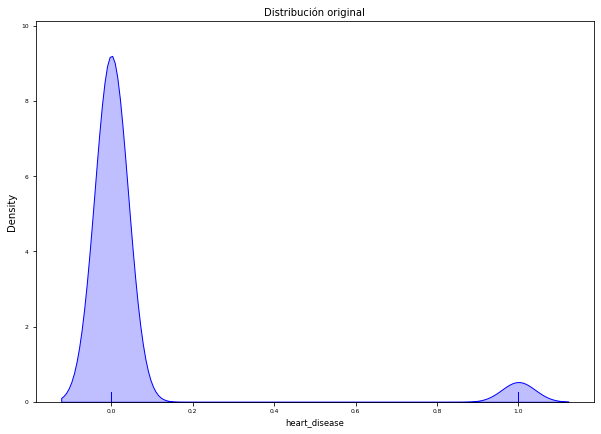

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
sns.distplot(
    data.heart_disease,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
)
axes.set_title("Distribución original", fontsize = 'medium')
axes.set_xlabel('heart_disease', fontsize='small') 
axes.tick_params(labelsize = 6)

En estos gráficos podemos visualizar como se distribuyen los datos. Hay que destacar un gran pico, donde se concentran todas aquellas personas que no padecen problemas de corazón, que suponen un 94,59%, frente a aquellas que sí que padecen dichos problemas, que representan un 5,40%.

A continuación, analizaremos el resto de variables de nuestro dataframe. Esto lo haremos con la ayuda de la función "dtypes" que nos proporcionará la información necesaria sobre nuestras variables.

In [18]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Una vez conocidas los tipos de variables, procederemos a analizar las variables numéricas.

In [19]:
data.select_dtypes(include=['float64', 'int']).describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Seguidamente, haremos una representación gráfica para visalizar como se distribuyen las variables numéricas. 

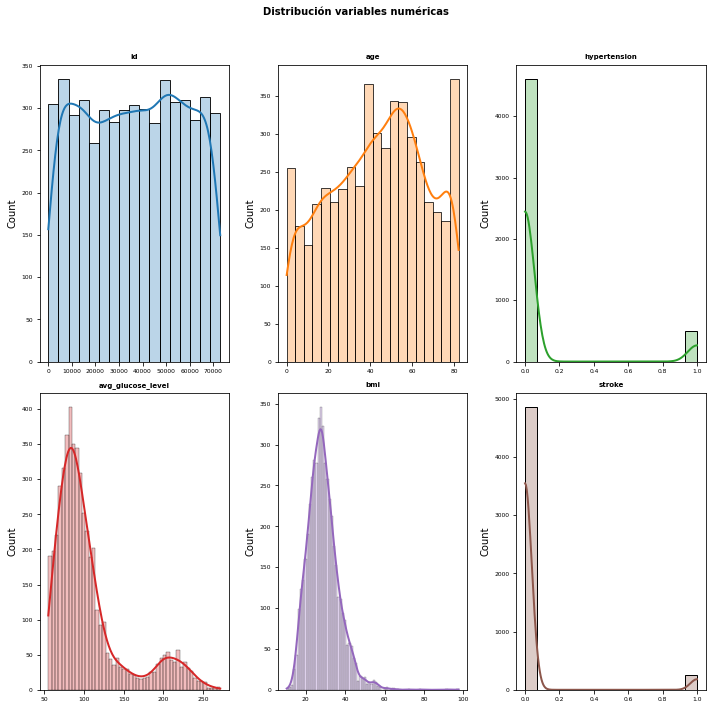

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('heart_disease')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Posteriormente, realizaremos el análisis de correlación para poder ver la relación de las variables y ver si hay un vínculo entre ellas. Y, por consiguiente estudiar si es preciso eliminar alguna variable. 

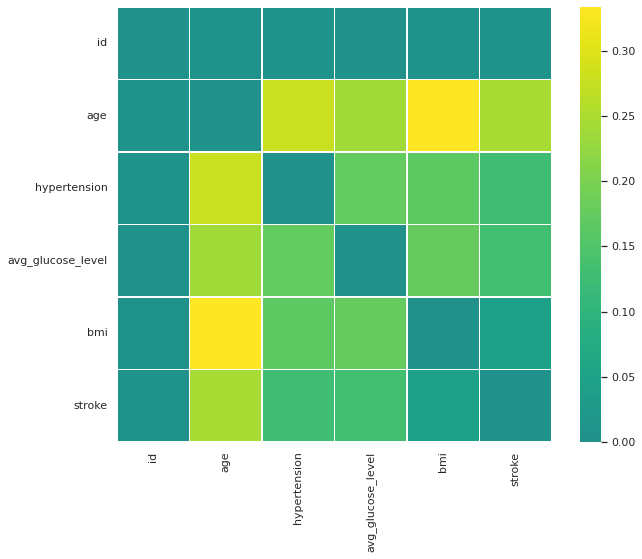

In [21]:
corr_matrix = get_corr_matrix(dataset = data[columnas_numeric], 
                metodo='pearson', size_figure=[10,8])

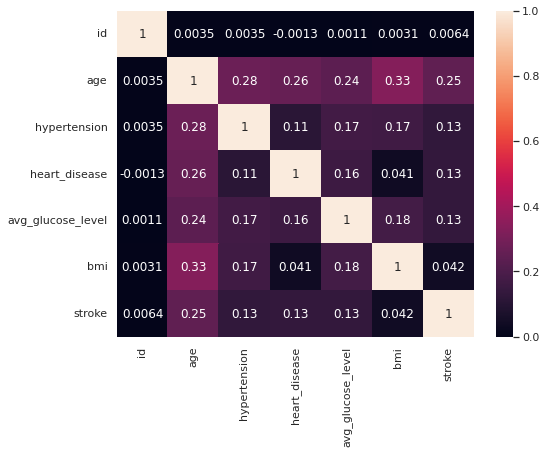

In [22]:
corr_df = data.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Observamos que ninguna variable esta excesivamente correlacionada con otra y que por lo tanto no deberemos de eliminar ninguna variable por aportar información redundante aunque esto es algo que analizaremos en el preprocesaado. A simple vista, podemos observar que la variable más correlacionada con "heart_disease" es la edad ("age") un alto nivel de glucosa ("avg_glucose_level") o haber padecido un derrame cerebral/ictus ("stroke").

Continuamos analizando las variables categóricas. 

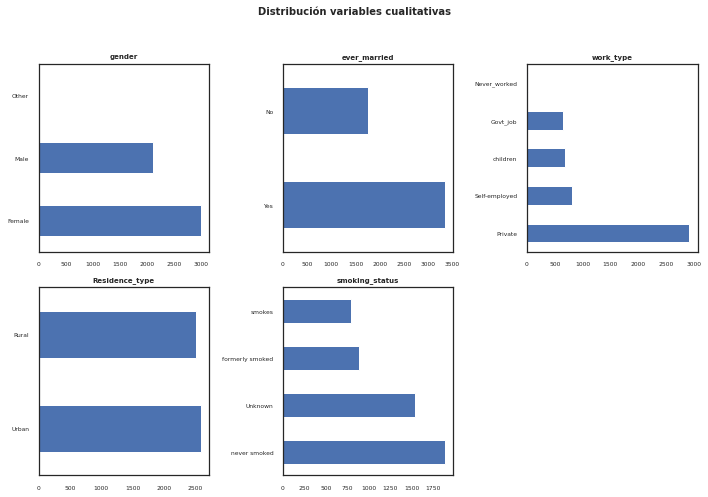

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flat
columnas_object = data.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    data[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")


for i in [5,6,7,8]: fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

Identificamos tanto en la variable "gender" como en la variable "work_type" hay ciertas opciones cuyo porcentaje asociado de respuestas no resulta representativo. En concreto, "Other" en la variable "Gender" o "Never_worked" en la variable "work_type". 
A continuación, comprobamos que esto es así ya que estas opciones podrían dificultar la separación en train y test y la validación cruzada.

In [24]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

En el caso de la opción "Other" consideramos que no es representativa y cómo agruparlo como mujer u hombre sería erroneo, hemos decidido no tener en cuenta este registro en nuestro estudio. 

In [25]:
data = data[(data['gender']=='Female') | 
                  (data['gender']=='Male')]
data.shape

(5109, 12)

A continuación, realizamos la misma evaluación pero de la variable "Work_type".

In [26]:
data.work_type.value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Consideramos "Never_worked" como no representativo. Sin embargo, creemos que no deberíamos agrupar a las personas que no trabajan con otro grupo ya que no presentan caracteristicas similares con otro grupo. Tampoco consideramos óptimo eliminar las observaciones que no trabajan ya que la información que aportan puede resultarnos interesante para poder evaluar si el no trabajar favorece un corazón sano. Sin embargo, deberemos de prestar atención con el fin de asegurarnos que la opción de never worked esté representada en ambos grupos train y test generados. 

Con el fin de analizar la relación de las variables con la variable objetivo, al igual que hicimos con la correlación en las variables cuantitativas haremos lo propio con las cualitativas. Al tratarse de variables que no son numéricas, observaremos la distribución que mantienen con "heart disease" con las variables cualitativas gráficas. 

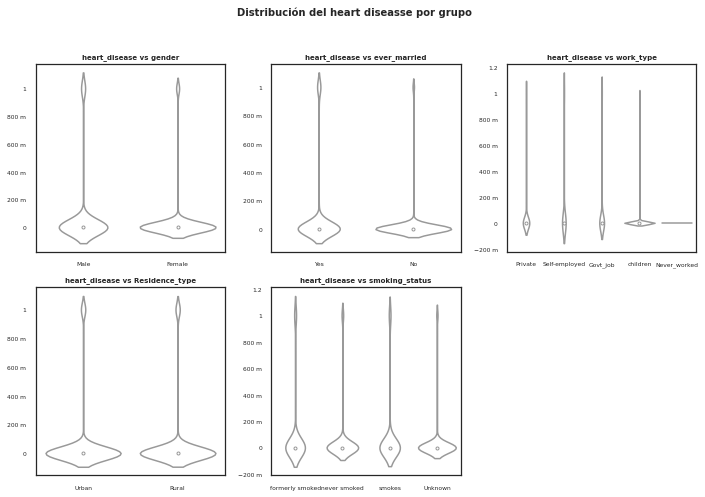

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flat
columnas_object = data.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'heart_disease',
        data  = data,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"heart_disease vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for i in [5,6,7,8]: fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del heart diseasse por grupo', fontsize = 10, fontweight = "bold");

A simple vista, podemos observar aspectos como que los Hombres ("Male") son más propensos a sufrir un "heart_disease" que las mujeres ("Female"). También destacamos la variable "ever_married" donde los que están casados son más propensos a sufrir un "heart_disease" ante los que no lo están. En cuanto a la variable "Residence_type", podríamos afirmar que no es relevante al existir el mismo nivel de propensión por parte de los que viven en una zona rural como urbana. Por último, es importante evlauar la distribución en cuanto a la gente que fuma. Hemos concluido que las gente que fumó anteriormente ("Formaly") y la gente que fuma ("Smokers") son más propensos a sufrir un "heart_disease" con respecto al resto de personas evaluadas.

**Procedemos a balancear los datos, ya que contamos con un conjunto de datos en el el que el número de observaciones no es el mismo para las clases que deseamos distinguir. Por lo tanto, para realizar el modelo de clasificación correcto, debemos tener unos datos con un número de observaciones similar para cada clase. Ya que, de no ser asi los algoritmos tenderían a favorecer la clase con mayor proporción de observaciones, obteniendo así un modelo de predicción erróneo. 
Para balancear los datos utilizaremos el modelo "oversampling", que consiste en generar datos sintéticcos con unas características similares a las observaciones de la clase minoritaria. Entonces, para realizar esta técnica utilizaremos el método RandomOverSample** .

In [28]:
from imblearn.over_sampling import RandomOverSampler
x = data[["id", "gender", "age", "hypertension", "ever_married", "work_type", "Residence_type",	"avg_glucose_level", 
          "bmi", "smoking_status", "stroke"]]
y = data["heart_disease"]
random_over = RandomOverSampler(sampling_strategy = "auto", 
                                random_state = 123)
x_over, y_over = random_over.fit_resample(x,y)
data_over = x_over
data_over["heart_disease"] = y_over
data = data_over

In [29]:
data.heart_disease.value_counts()

1    4833
0    4833
Name: heart_disease, dtype: int64

In [30]:
data.shape

(9666, 12)

**Una vez tenemos los datos balanceados, realizamos la separación en train y test**

In [31]:
from sklearn.model_selection import train_test_split
X_data, X_data_test, y_data, y_data_test = train_test_split(data.drop('heart_disease',axis=1), 
                                                                    data['heart_disease'], 
                                                                     stratify=data['heart_disease'], 
                                                                     test_size=0.2)
data_train = pd.concat([X_data, y_data],axis=1)
data_test = pd.concat([X_data_test, y_data_test],axis=1)

In [32]:
print('== Train\n', data_train['heart_disease'].value_counts(normalize=True))
print('== Test\n', data_test['heart_disease'].value_counts(normalize=True))

== Train
 1    0.5
0    0.5
Name: heart_disease, dtype: float64
== Test
 0    0.5
1    0.5
Name: heart_disease, dtype: float64


**PREPROCESADO**

A continuación, procederemos a realizar el preprocesado de los datos una vez hemos realizado la partición en train y test. Este paso es uno de los más importantes e implica llevar a cabo tareas de extracción, limpieza, transformación y selección de las variables relevantes. 

Teniendo en cuenta que hemos analizado previamente las variables que contiene el dataset, continuaremos analizando los valores missing.

In [33]:
data_null_columns = data_train.isnull().sum().sort_values(ascending=False)
data_null_rows = data_train.isnull().sum(axis=1).sort_values(ascending=False)
print(data_null_columns.shape, data_null_rows.shape)

data_null_columnas = pd.DataFrame(data_null_columns, columns=['nulos_columnas'])     
data_null_filas = pd.DataFrame(data_null_rows, columns=['nulos_filas'])  
data_null_filas['target'] = data['heart_disease'].copy()
data_null_columnas['porcentaje_columnas'] = data_null_columnas['nulos_columnas']/data_null_filas.shape[0]
data_null_filas['porcentaje_filas']= data_null_filas['nulos_filas']/data_train.shape[1]
data_null_columnas

(12,) (7732,)


,nulos_columnas,porcentaje_columnas
bmi,576,0.074496
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
smoking_status,0,0.000000


Observamos que tan solo la variable "bmi" presenta valores nulos. Teniendo en cuenta que bmi es una variable que hace referencia a la masa corporal y toma valores numéricos hemos decidido sustituir los valroes missing por la media de la masa corporal de los datos que poseemos. 

In [34]:
list_var_continuous = list(data_train.select_dtypes('float').columns)
data_train[list_var_continuous] = data_train[list_var_continuous].apply(lambda x: x.fillna(x.mean()))
data_test[list_var_continuous] = data_test[list_var_continuous].apply(lambda x: x.fillna(x.mean()))
print("Nulos: " +
      str(data_train[list_var_continuous].isna().sum()))

Nulos: age                  0
avg_glucose_level    0
bmi                  0
dtype: int64


In [35]:
X_train = data_train.drop('heart_disease',axis=1)
X_test = data_test.drop('heart_disease',axis=1)
y_train = data_train['heart_disease']
y_test = data_test['heart_disease']


Una vez tratados los valores missing, procederíamos a tratar los outliers pero, como nuestro dataset tiene pocos registros hemos identificado que tratarlos sería un error. Deberíamos incluir un mayor número de datos en el modelo para que tratar los outliers no generara problemas a futuro. En caso de haber sido óptimo, hubieramos tratado los outliers haciendo uso de los cuantiles.

**A continuación, continuaremos tratando las variables categóricas**

Para ello, utilizaremos el método One Hot Encoding. Este modelo convierte las variables en binarias por lo que solo tomaremos aquellas que son categóricas. Fianlmente solo utilizaremos las variables 'gender', 'ever_married', 'work_type', 'Residence_type' y 'smoking_status'.

In [36]:
list_columns_cat = list(data_train.select_dtypes("object").columns)
list_other = list(set(data_train.columns)-set(list_columns_cat))

In [37]:
ohe = ce.OneHotEncoder(cols=list_columns_cat)
model = ohe.fit(X_train, y_train)
model

OneHotEncoder(cols=['gender', 'ever_married', 'work_type', 'Residence_type',
                    'smoking_status'])

In [38]:
Train = round(model.transform(X_train, y_train),2)
Test = round(model.transform(X_test, y_test),2)

**Continuaremos el preprocesamiento escalando las variables ahora que todas ellas son numéricas.**

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_scaled = scaler.fit(Train)
Train_scaled = round(pd.DataFrame(scaler.transform(Train), columns=Train.columns, index=Train.index),2)
test_scaled = round(pd.DataFrame(scaler.transform(Test), columns=Test.columns, index=Test.index),2)

Una vez hemos finalizado el preprocesado y teniendo en cuenta que no debemos de prescindir de ninguna variable que aporte información redundante (al analizar la varianza) continuaremos generando distintos modelos y evaluando la eficiencia de estos hasta seleccionar el mejor. Aquel que nos ayude a prevenir si un paciente padecerá un "heart_disease" de forma más eficiente.

**MODELO**

Decidimos utilizar cuatro modelos, evaluando posteriormente estos por medio de distintas métricas para determinar cuál es más óptimo. 

En primer lugar, recurrimos a la Regresión Logística (primer modelo de clasificación y muy utilizado en el sector de la medicina). Este modelo aunque es sensible a variables correlacionadas es rápido, limpio y su resultado es de fácil interpretación por lo que consideramos que al poseer un dataset con variables poco correlacionadas este modelo sería interesante y fácil de interpretar para los profesionales de la salud. 
**Como puede resultar un modelo excesivamente simple para aplicarlo a datos reales, en el que su desempeño se ve afectado por el trato incorrecto de los valores missing.**

En segundo lugar hemos utilizado el Árbol de decisión simple ya que este aporta validez por encima de otros modelos como el Random forest.

En trecer lugar utilizamos el Random Forest. Como nuestro dataset no presenta altos niveles de varianza y para hacer frente al posible efecto del ruido de los datos hemos decidido recurrir a este modelo que al contrario de la Regresión Logística es muy robusto a outliers de forma que presenta un muy buen desempeño en datos reales. 

En cuarto y último lugar, hemos recurrido al modelo Gradient Boost que está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial por lo que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. 
Este modelo se caracteriza por evaluar todos predictores ignorando aquellos que no son relevantes. Si se realiza una buena optimización de hiperparámetros, se suelen obtener resultados ligeramente superiores al Random Forest. Este modelo no se ven muy influenciados por outliers.

**En primer lugar, realizamos la regresión logística**

In [40]:
clf = LogisticRegression(solver='newton-cg', max_iter=200)
model_glm = clf.fit(Train_scaled, y_train)
Test_predicted = model_glm.predict_proba(test_scaled)
Train_predicted = model_glm.predict_proba(Train_scaled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



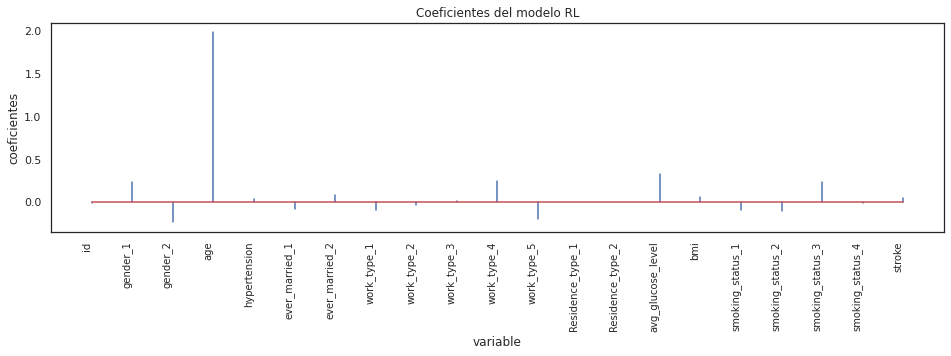

In [41]:
df_coeficientes = pd.DataFrame(
                        {'predictor': Train_scaled.columns,
                         'coef': model_glm.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo RL');

En este primer gráfico, podemos observar las variables que mejor explican en mayor medida la posibilidad de que un paciente tenga problemas de corazón. Destacando por encima de la todas la variable edad. Luego, también podríamos mencionar otras variables como el nivel de glucosa o si fuman, entre otros.

La regresión logística en una herramienta para realizar clasificación, por lo que trabajaremos con clasificación binaria.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

best mean cross-validation score: 0.786
best parameters: {'C': 7.943282347242813}


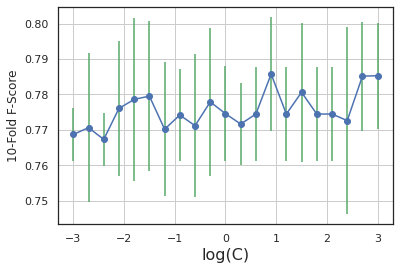

In [42]:
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(Train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold F-Score')
plt.grid()

Procederemos a representar la curva Roc de Train y Test dado que nuestros datos están balanceados. 
La curva Roc refleja las relaciones entre las personas que han sido correctamente clasificadas como que tienen una "heart_disease" y las que no han sido correctamente clasificadas. 

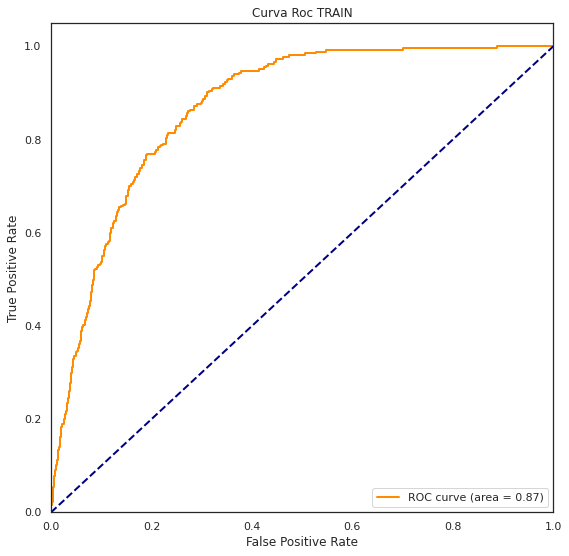


*************************************************************

El coeficiente de GINI es: 0.74

El área por debajo de la curva ROC es: 0.87

*************************************************************


0

In [43]:
plot_roc_gini(y_train, Train_predicted[:,1],
              size_figure=[9,9], tittle = 'Curva Roc TRAIN')

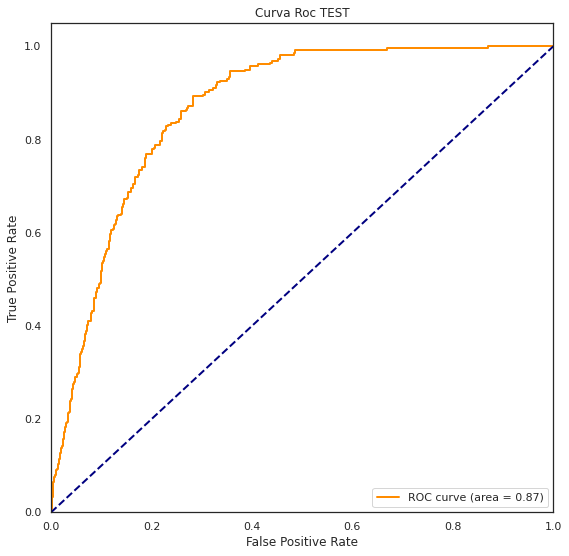


*************************************************************

El coeficiente de GINI es: 0.73

El área por debajo de la curva ROC es: 0.87

*************************************************************


0

In [ ]:
plot_roc_gini(y_test, Test_predicted[:,1],
              size_figure=[9,9], tittle = 'Curva Roc TEST')

Podemos observar como el área por debajo de la curva roc (AUC) es de 0.87. Como bien sabemos el mejor modelo es el que más cercano esté a 1. Este modelo se considera excelente ya que está por encima del 80%. 

Procederemos a hacer la **matriz de confusión.** 
Esta representa los acierto y fallos del modelo sobre el subconjunto. 

In [44]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Train_scaled,y_train)
y_pred = lr.predict(test_scaled)

confmat_test  = confusion_matrix(y_test, y_pred)

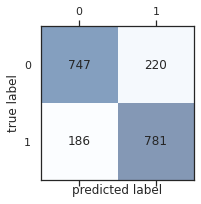

ACC:  0.7900723888314375
SEN:  0.8076525336091003
ESP:  0.7724922440537746
PPV:  0.7802197802197802
FSC:  0.7936991869918698


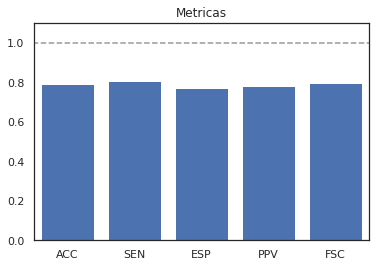

In [45]:
plot_confusion_matrixdef(confmat_test)
calcula_metricas(confmat_test)

Procederemos a analizar las métricas de la matriz de confusión respecto a test que sirve para evaluar el rendimiento de los modelos de clasificación. En primer lugar observamos el Accuracy (ACC) que es la métrica más básica de las que veremos y la medida más directa de la calidad de los clasificadores. Tiene sentido analiazar esta métrica dado que los datos están balanceados. Podemos afirmar que este resultado es alto 0.79 pero podería ser mejor. 
En cuanto a la Sensibilidad (SEN), es la proporción de casos positivos que fueron correctamente identificadas. Es el resultado más alto en cuanto a las métricas analizadas, donde el modelo está identificando adecuadamente al 83% de los casos positivos.  
En cuanto a la Especificidad, es la probabilidad de que un caso de individuo sin cardiopatía sea realmente negativo o capacidad del estimador de dar casos negativos ("0"). En este caso la probabilidad es del 76%. 


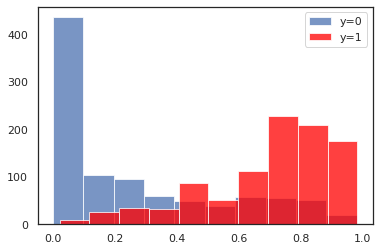

In [46]:
y_prob = lr.predict_proba(test_scaled)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)
 
plt.hist(y_prob[idx_0],density=0, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1],density=0, facecolor='red', alpha=0.75,label='y=1')
plt.legend(loc=1)
plt.show()

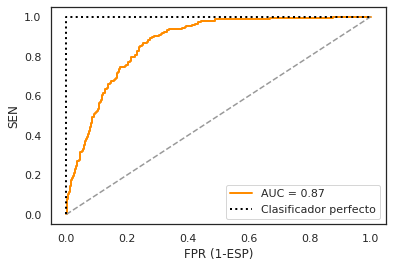

In [47]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Podemos observar como el área por debajo de la curva roc (AUC) es de 0.87. Como bien sabemos el mejor modelo es el que más cercano esté a 1. Este modelo se considera excelente ya que está por encima del 80%. 

Nos interesa que la curva se acerque lo máximo posible a 1 en el eje y, de manera que el hecho de aumentar la sensibilidad no haga que nuestro modelo introduzca más falsos positivos.

**A continuación, procederemos a evaluar el Árbol de decisión.**

In [48]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [49]:
X_tree = Train_scaled
y_tree = y_train
tree = DecisionTreeClassifier(random_state=0).fit(X_tree,y_tree)
y_predtree = tree.predict(test_scaled)

In [50]:
tree.fit(X_tree, y_tree)

DecisionTreeClassifier(random_state=0)

In [51]:
tree.score(Train_scaled,y_train)

1.0

In [52]:
tree.score(test_scaled,y_predtree)

1.0

In [53]:
data_evaltree = test_scaled.copy()
data_evaltree['heart_disease'] =  tree.predict(test_scaled)
data_evaltree.dtypes
rmse_tree = np.sqrt(((data_evaltree['heart_disease'] - data_evaltree['heart_disease'])**2).mean())
rmse_tree

0.0

best mean cross-validation score: 0.942
best parameters: {'max_depth': 14}


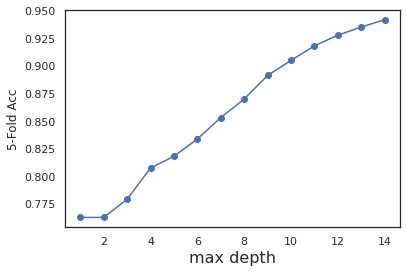

In [54]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(Train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

Podemos observar como la profundidad de nuestro árbol es de 14 nodos, y la media más alta de la validación cruzada es del 93%.

In [55]:
maxDepthOptimotree = grid.best_params_['max_depth']
treemodelclass = DecisionTreeClassifier(max_depth=maxDepthOptimotree).fit(Train_scaled,y_train)

print("Train: ",treemodelclass.score(Train_scaled,y_train))
print("Test: ",treemodelclass.score(test_scaled,y_test))

Train:  0.9623642007242628
Test:  0.9451913133402275


In [56]:
featurestree = [(a,b) for a,b in zip(Train_scaled.columns, tree.feature_importances_)]
featurestree = sorted(featurestree, key= lambda c:c[1], reverse=True)

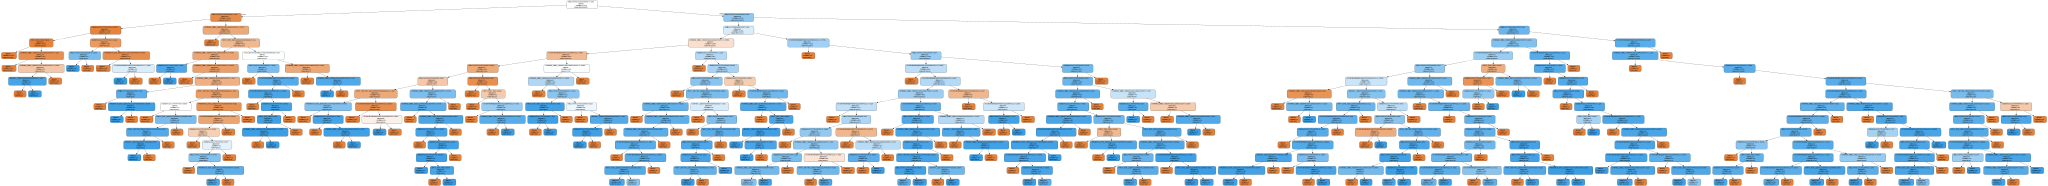

In [57]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(treemodelclass, out_file=None, 
                         feature_names=featurestree,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

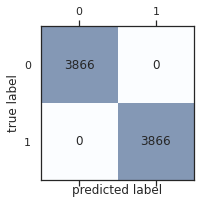

ACC:  1.0
SEN:  1.0
ESP:  1.0
PPV:  1.0
FSC:  1.0


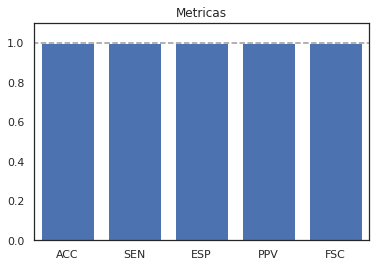

In [58]:
confmattree = confusion_matrix(y_train, tree.predict(X_tree))
plot_confusion_matrixdef(confmattree)
calcula_metricas(confmattree)

Al hacer la predicción del modelo con train podemos observar como todas las métricas son iguales a "1" dado los datos que se encuentran en la matriz de confusión donde los falsos negativos y positivos son iguales a "0" y los verdaderos negativos y positivos tienen la misma dimensión.

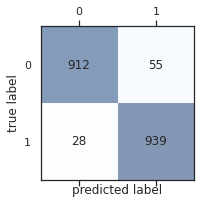

ACC:  0.9570837642192348
SEN:  0.9710444674250258
ESP:  0.9431230610134437
PPV:  0.9446680080482898
FSC:  0.9576746557878634


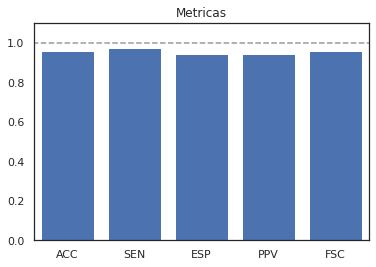

In [59]:
confmat_testtree = confusion_matrix(y_test, y_predtree)
plot_confusion_matrixdef(confmat_testtree)
calcula_metricas(confmat_testtree)

Como hemos visto con anterioridad, accuracy es la medida más directa de la calidad de los clasificadores. En este modelo con respecto a test vemos que el ACC de 0,97 por lo tanto, el modelo acierta el 97% de las veces. También destacan otras métricas como su elevada sensibilidad de 0.99 y especificidad de 0.96.

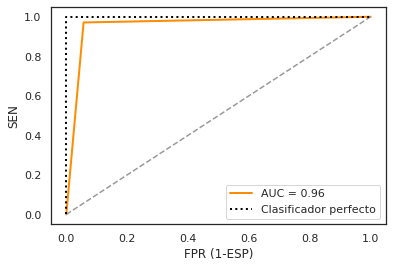

In [60]:
from sklearn.metrics import roc_curve, auc

ejextree, ejeytree, _ = roc_curve(y_test, y_predtree)
roc_auctree = auc(ejextree, ejeytree)

plt.figure()
plt.plot(ejextree, ejeytree, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auctree)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Podemos observar como el área por debajo de la curva roc (AUC) es de 0.96. Como bien sabemos el mejor modelo es el que más cercano esté a 1. Podríamos decir que estamos ante datos muy buenos y un modelo muy optimizado, ya que ha superado el 90%.

**MODELO RANDOM FOREST**

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [62]:
forest = RandomForestRegressor()

In [63]:
X_forest = Train_scaled
y_forest = y_train

X_forest_test = test_scaled
y_forest_test = y_test

In [64]:
rf = RandomForestClassifier(random_state=0).fit(X_forest,y_train)
y_predrf = rf.predict(X_forest_test)

In [65]:
y_train.value_counts()


1    3866
0    3866
Name: heart_disease, dtype: int64

In [66]:
np.unique(rf.predict(X_forest),return_counts=True)

(array([0, 1]), array([3866, 3866]))

In [67]:
y_test.value_counts()

0    967
1    967
Name: heart_disease, dtype: int64

In [68]:
np.unique(y_predrf,return_counts=True)

(array([0, 1]), array([950, 984]))

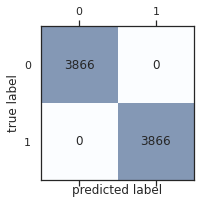

ACC:  1.0
SEN:  1.0
ESP:  1.0
PPV:  1.0
FSC:  1.0


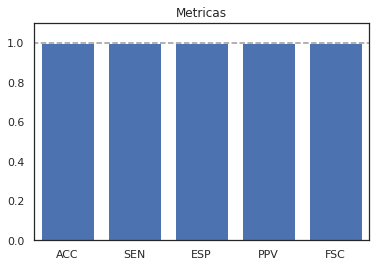

In [69]:
confmat = confusion_matrix(y_train, rf.predict(X_forest))
plot_confusion_matrixdef(confmat)
calcula_metricas(confmat)

Podemos observar como al igual que en el modelo de árboles de decisión simple al hacer la matriz de confusión con respecto a train obteniamos los mismos resultados. 

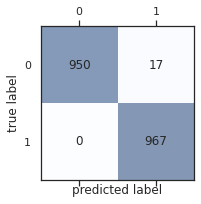

ACC:  0.9912099276111686
SEN:  1.0
ESP:  0.9824198552223371
PPV:  0.9827235772357723
FSC:  0.99128651973347


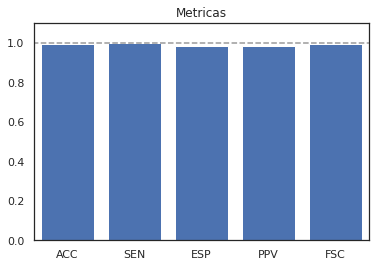

In [70]:
confmat_test = confusion_matrix(y_test, y_predrf)
plot_confusion_matrixdef(confmat_test)
calcula_metricas(confmat_test)

En este modelo nos sale un ACC de 0,99 por lo tanto, el modelo acierta el 99% de las veces. Tiene una Sensibilidad de 1 y una Especificidad de 0.98. Por lo que podemos afirmar que este modelo es casi perfecto.

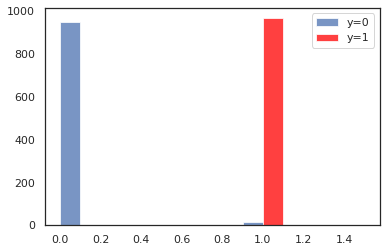

In [71]:
y_predrf = rf.predict(X_forest_test)

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_predrf[idx_0],density=0, alpha=0.75,label='y=0')
plt.hist(y_predrf[idx_1],density=0, facecolor='red', alpha=0.75,label='y=1')
plt.legend(loc=1)
plt.show()

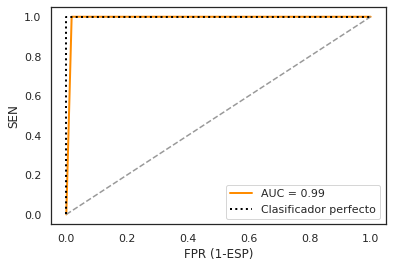

In [72]:
from sklearn.metrics import roc_curve, auc

ejexforest, ejeyforest, _ = roc_curve(y_test, y_predrf)
roc_aucforest = auc(ejexforest, ejeyforest)

plt.figure()
plt.plot(ejexforest, ejeyforest, color='darkorange',lw=2, label='AUC = %0.2f' % roc_aucforest)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Podemos observar como el área por debajo de la curva roc (AUC) es de 0.99. Como bien sabemos el mejor modelo es el que más cercano esté a 1. Por lo tanto estamos ante un AUC casi perfecto.


best mean cross-validation score: 0.973
best parameters: {'max_depth': 14}


Text(0, 0.5, '5-Fold A')

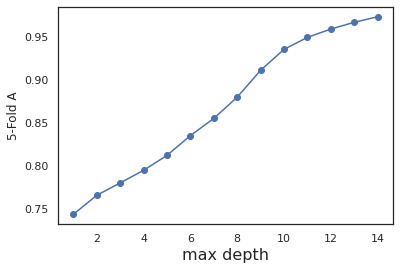

In [73]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,15)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(n_estimators = 200), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(Train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold A')

In [74]:
maxDepthOptimorf = grid.best_params_['max_depth']
rf = RandomForestClassifier(n_estimators = 200, max_depth=maxDepthOptimorf).fit(Train,y_train)

print("Train: ",rf.score(Train,y_train))
print("Test: ",rf.score(Test,y_test))

Train:  0.9957320227625452
Test:  0.9813857290589452


A continuación, analizamos las variables que según Random Forest son las que explican en mayor medida si un paciente sufrirá un ataque al cerebro

In [75]:
features_rf = [(a,b) for a,b in zip(Train.columns, rf.feature_importances_)]
features_rf = sorted(features_rf, key= lambda c:c[1], reverse=True)

In [76]:
import plotly.express as px
fig = px.bar(x=[a for a,b in features_rf], y=[b for a,b in features_rf])
fig.show()

Sin tener en cuenta el ID, que es una variable que corresponde a la forma en la que el dueño del dataset identifica los registros, podemos observar que las variables que mejor explican la posibilidad de que un paciente padezca un problema de corazón (heart_disease): la edad ("age"), el índice de masa corporal ("bmi") y el nivel de glucosa en sangre ("avg_glucose_level"). 

También, hemos podido observar que el tipo de trabajo del paciente influye aunque no en gran medida sobre la posibilidad de que este enferme de corazón. Los pacientes cuyo trabajo es el tipo de trabajo 3 ("work_type_3") que corresponde a aquellos con un Government Job ("Govt_job") tienen una mayor probabilidad de sufrir un heart disease que por ejemplo los que tienen un tipo de trabajo 4 ("work_type_4") que corresponde a autonomos. Estos ultimos, a su vez, tienen una mayor probabilidad de sufrir un problema de corazón que el resto de trabajos. 

Hemos observado algo parecido con las residencias. En zonas urbanas ("Residence_type_1") los pacientes poseen más problemas de corazón que aquellos que residen en zonas rurales ("Residence_type_2"). También, podemos concluir que aquellos que fuman poseen mayor probabilidad de tener problemas cardíacos. 

Además, hemos podido observar que otras enfermedades como la hipertensión ("hypertension") o los ictus ("stroke") favorecen la presencia de cardiopatías ("heart_diseas"). 

In [77]:
Train.head(10)

,id,gender_1,gender_2,age,hypertension,ever_married_1,ever_married_2,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,Residence_type_1,Residence_type_2,avg_glucose_level,bmi,smoking_status_1,smoking_status_2,smoking_status_3,smoking_status_4,stroke
8525,12618,1,0,79.0,0,1,0,1,0,0,0,0,1,0,96.79,24.7,1,0,0,0,0
1645,14222,0,1,25.0,0,0,1,0,1,0,0,0,1,0,78.59,37.2,0,1,0,0,0
1904,39849,1,0,39.0,1,0,1,0,1,0,0,0,1,0,80.99,39.8,1,0,0,0,0
4135,23439,1,0,63.0,0,0,1,0,1,0,0,0,1,0,75.00,25.7,0,0,1,0,0
4953,64661,0,1,81.0,0,0,1,1,0,0,0,0,1,0,57.42,33.7,0,1,0,0,0
9144,16812,0,1,82.0,0,1,0,1,0,0,0,0,0,1,229.58,23.7,1,0,0,0,0
1698,6879,0,1,44.0,0,0,1,0,0,1,0,0,1,0,215.90,41.8,0,0,1,0,0
4495,72184,0,1,43.0,0,1,0,1,0,0,0,0,1,0,89.73,23.5,0,0,0,1,0
2132,14479,0,1,71.0,0,1,0,0,1,0,0,0,1,0,187.88,29.2,0,0,0,1,0
5059,60271,1,0,78.0,0,1,0,0,1,0,0,0,1,0,60.22,29.7,0,0,0,1,0


**Por último, decidimos realizar el modelo Gradient Boost con el fin de observar si mejora el accuracy a partir del uso de un arbol de decisión secuencial en vez de un árbol de decisión paralelo.**

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

In [79]:
boost = GradientBoostingClassifier()

In [80]:
X_boost = Train_scaled
y_boost = y_train
X_test_boost = test_scaled
y_test_boost = y_test

In [81]:
boost = GradientBoostingClassifier()
boost.fit(X_boost, y_boost)
boost.score(X_boost, y_boost)

0.8786859803414382

In [82]:
boost.score(X_test_boost, y_test_boost)

0.8769389865563598

In [83]:
rmse_gboost = mean_squared_error(y_test_boost, boost.predict(X_test_boost), squared=False)
rmse_gboost

0.3508005322738837

In [84]:
y_predboost = boost.predict(X_test_boost)

best mean cross-validation score: 0.982
best parameters: {'max_depth': 12}


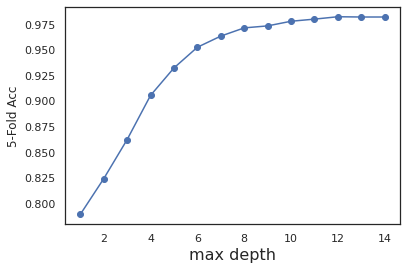

In [85]:
maxDepthboost = range(1,15)
param_grid = {'max_depth': maxDepthboost }

gridboost = GridSearchCV(GradientBoostingClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
gridboost.fit(Train, y_train)
print("best mean cross-validation score: {:.3f}".format(gridboost.best_score_))
print("best parameters: {}".format(gridboost.best_params_))

scoresboost = np.array(gridboost.cv_results_['mean_test_score'])
plt.plot(maxDepthboost,scoresboost,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

Es el modelo que cuenta con la mayor media de validacion cruzada con un resultado del 98% con respecto a los otros modelos estudiados anteriormente. 

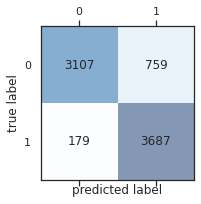

ACC:  0.8786859803414382
SEN:  0.9536989136057941
ESP:  0.8036730470770822
PPV:  0.8292847503373819
FSC:  0.8871511068334937


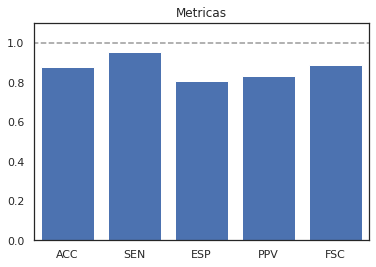

In [86]:
confmatboost = confusion_matrix(y_train,boost.predict(X_boost) )
plot_confusion_matrixdef(confmatboost)
calcula_metricas(confmatboost)

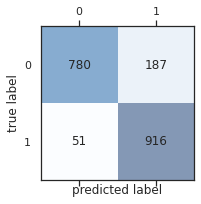

ACC:  0.8769389865563598
SEN:  0.9472595656670114
ESP:  0.8066184074457083
PPV:  0.8304623753399819
FSC:  0.885024154589372


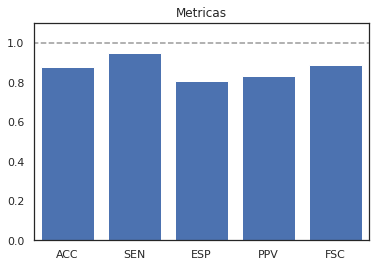

In [87]:
confmatboost_test = confusion_matrix(y_test, y_predboost)
plot_confusion_matrixdef(confmatboost_test)
calcula_metricas(confmatboost_test)


La matriz de confusión y sus métricas respecto a test son buenas. El Accuracy es de 0.87 lo que significa que el modelo acierta el 87% de las veces. Podemos ver que la Sensibilidad es de 0.95 y la Especificidad es menor de lo esperado. 

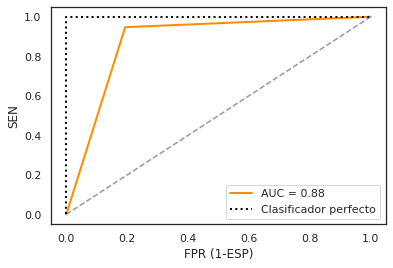

In [88]:
from sklearn.metrics import roc_curve, auc

ejexboost, ejeyboost, _ = roc_curve(y_test, y_predboost)
roc_aucboost = auc(ejexboost, ejeyboost)

plt.figure()
plt.plot(ejexboost, ejeyboost, color='darkorange',lw=2, label='AUC = %0.2f' % roc_aucboost)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Podemos observar como el área por debajo de la curva roc (AUC) es de 0.88. Como bien sabemos el mejor modelo es el que más cercano esté a 1. Este modelo se considera excelente ya que está por encima del 80%. 

**CONCLUSIÓN DE LOS MODELOS**

Tras haber abordado el problema de clasificación planteado y analizando las variables, pudimos destacar como ninguna variable estaba suficientemente correlacionada para eliminarla. Luego, realizamos el balanceo de los datos antes de realizar la separación de train y test ya que, era de vital importancia para poder realizar un modelo de clasificación correcto. 

A continuación, comenzamos el preprocesado antes de dirigirnos al análisis de los modelos.

En primer lugar, realizamos la regresión logística. Donde obtuvimos un AUC en train y test de 0.87, y una exactitud en el modelo de 0.79. 

Luego, al realizar el árbol de decisión simple, obtuvimos un AUC en test del 96% y un Accuracy del 95%. Estos resultados reflejan la perfección del modelo, pero al realizar el Random Forest, donde nos dio un Accuracy del 99% y un AUC en test del 99%, pudimos observar que el Random Forest tiene los resultados más altos en comparación al resto de modelos. Por lo que podríamos destacar que este modelo será el elegido al ser casi perfecto.

Por último, con el Gradient Boost obtuvimos una exactitud del 87% y un AUC en test del 88%. Estos resultados son excelentes pero los analizados anteriormente son mejores. 

En definitiva, el mejor modelo es el Random Forest, ya que es un modelo casi perfecto al tener una exactitud, sensibilidad y especificidad casi del 100%. 